In [1]:
#pip install scikit-learn
import numpy as np
from numpy.random import randn
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import collections

def linearSCM (epsilon_x1, epsilon_x2, epsilon_x3, epsilon_x4):
    x2 = epsilon_x2
    x1 = epsilon_x1
    x3 = 5 * x1 + 4 * x2 + epsilon_x3
    x4 = 6 * x3 + epsilon_x4 
    if x2.size > 1:
        df = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3, "x4": x4})
    else:
        df = pd.DataFrame({"x1": [x1], "x2": [x2], "x3": [x3], "x4": [x4]})
    return df

We compare samples from two population, one treated, i.e. in which $P(X_4|do(X_1=1))$, and one untreated, i.e. in which $P(X_4|do(X_1=0))$. 
Each sample represents a patient that can either be treated or not, but not both at the same time.

<AxesSubplot:xlabel='x2', ylabel='x4'>

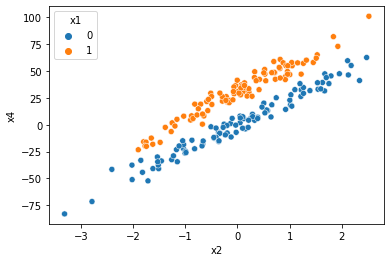

In [38]:
epsilon_x2 = randn(100)
epsilon_x3 = randn(100)
epsilon_x4 = randn(100)

df1_2 = linearSCM(1, epsilon_x2, epsilon_x3, epsilon_x4)

epsilon_x2 = randn(100)
epsilon_x3 = randn(100)
epsilon_x4 = randn(100)

df0_2 = linearSCM(0, epsilon_x2, epsilon_x3, epsilon_x4)
df01_2 = pd.concat([df0_2,df1_2])
sns.scatterplot(data = df01_2, x="x2", y="x4", hue="x1")

We can plot how $X_4$ changed in the two populations, but we can only judge on a population level, e.g. in terms of how their means differ.

Instead we are interested to see what would happen to each individual if they were assigned to a different group.

Even when we plot $X_3$ vs $X_4$, we can see that as expect the distribution is probably the same, i.e. $P(X_4|X_3, do(X_1=0)) = P(X_4|X_3, do(X_1=1)$, but we have no idea about the individual effects per patient, i.e. where each point would move on the line if it changed the treatment assignment.


<AxesSubplot:xlabel='x2', ylabel='x3'>

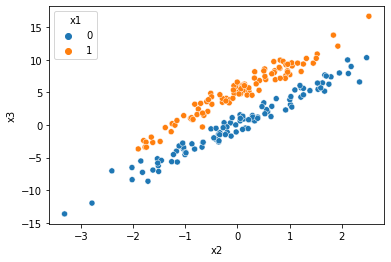

In [54]:
sns.scatterplot(data = df01_2, x="x2", y="x3", hue="x1")

<AxesSubplot:xlabel='x3', ylabel='x4'>

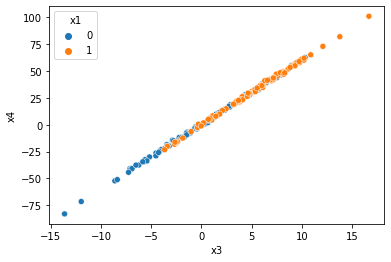

In [40]:
sns.scatterplot(data = df01_2, x="x3", y="x4", hue="x1")

We are going to construct a smaller dataset with just 6 samples now to show how we can predict, after we have observed the effects of the treatment assignment, the counterfactual outcome, i.e. th outcome that would have happened with a different treatment assignment.

In [55]:
n_samples=3

epsilon_x2 = randn(n_samples)
epsilon_x3 = randn(n_samples)
epsilon_x4 = randn(n_samples)

df1 = linearSCM(1, epsilon_x2, epsilon_x3, epsilon_x4)

epsilon_x2 = randn(n_samples)
epsilon_x3 = randn(n_samples)
epsilon_x4 = randn(n_samples)

df0 = linearSCM(0, epsilon_x2, epsilon_x3, epsilon_x4)

df01 = pd.concat([df0,df1])
df01

,x1,x2,x3,x4
0,0,-0.924901,-4.602793,-28.985712
1,0,0.159378,-2.006137,-12.131368
2,0,-0.191877,-0.823301,-5.487288
0,1,0.262490,7.222740,41.988136
1,1,-0.051005,5.791781,35.576709
2,1,-0.365743,2.944476,19.422212


<AxesSubplot:xlabel='x2', ylabel='x4'>

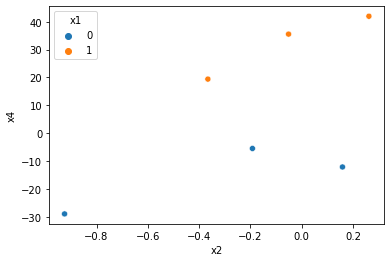

In [66]:
sns.scatterplot(data = df01, x="x2", y="x4", hue="x1")

We care about predicting what would have happen to each individual given that they were in the other *counterfactual* group.
This means for the patients that got the treatment ($X_1=1$) we want to predict what would have happened if they did not get the treatment, i.e. if $X_1=0$.
We first need to reconstruct for each of the patients the noise variables from the observed variables:

In [67]:
df01["epsilon_x2"] = df01["x2"]
df01["epsilon_x3"] = df01["x3"] - [5] * df01["x1"] - [4] * df01["x2"]
df01["epsilon_x4"] = df01["x4"] - [6] * df01["x3"]

df01

,x1,x2,x3,x4,epsilon_x2,epsilon_x3,epsilon_x4,x1c,x2c,x3c,x4c,is_factual
0,0,-0.924901,-4.602793,-28.985712,-0.924901,-0.903188,-1.368955,1,-0.924901,-4.602793,-28.985712,True
1,0,0.159378,-2.006137,-12.131368,0.159378,-2.643650,-0.094546,1,0.159378,-2.006137,-12.131368,True
2,0,-0.191877,-0.823301,-5.487288,-0.191877,-0.055793,-0.547480,1,-0.191877,-0.823301,-5.487288,True
0,1,0.262490,7.222740,41.988136,0.262490,1.172778,-1.348303,0,0.262490,7.222740,41.988136,True
1,1,-0.051005,5.791781,35.576709,-0.051005,0.995800,0.826023,0,-0.051005,5.791781,35.576709,True
2,1,-0.365743,2.944476,19.422212,-0.365743,-0.592551,1.755359,0,-0.365743,2.944476,19.422212,True


We can now compute for each patient exactly what would have happen in the counterfactual case and save it as a counterfactual copy of each variable. For example, the counterfactual copy of "x1" will be "x1c". 
 

In [65]:
counterfactual_patients = pd.DataFrame()

x1c = []
x2c = []
x3c = []
x4c = []

for itern, patient in df01.iterrows():
    
    if patient["x1"] == 0:
        counterfactual_x1 = 1
    if patient["x1"] == 1:
        counterfactual_x1 = 0
    
    counterfactual_patient = linearSCM(counterfactual_x1, patient["epsilon_x2"], patient["epsilon_x3"], patient["epsilon_x4"])
    counterfactual_patients = pd.concat([counterfactual_patients,counterfactual_patient])
    
    x1c.append(counterfactual_x1)
    x2c.append(patient["x2"])
    x3c.append(patient["x3"])
    x4c.append(patient["x4"])

df01["x1c"] = x1c
df01["x2c"] = x2c
df01["x3c"] = x3c
df01["x4c"] = x4c

# We use this just to plot things in an easier way
df01["is_factual"]=True
counterfactual_patients["is_factual"]=False

# We create this just to plot things in an easier way
df_all = pd.concat([counterfactual_patients,df01])
df01

AttributeError: 'float' object has no attribute 'size'

In [64]:
df01

,x1,x2,x3,x4,epsilon_x2,epsilon_x3,epsilon_x4,x1c,x2c,x3c,x4c,is_factual
0,0,-0.924901,-4.602793,-28.985712,-0.924901,-0.903188,-1.368955,1,-0.924901,-4.602793,-28.985712,True
1,0,0.159378,-2.006137,-12.131368,0.159378,-2.643650,-0.094546,1,0.159378,-2.006137,-12.131368,True
2,0,-0.191877,-0.823301,-5.487288,-0.191877,-0.055793,-0.547480,1,-0.191877,-0.823301,-5.487288,True
0,1,0.262490,7.222740,41.988136,0.262490,1.172778,-1.348303,0,0.262490,7.222740,41.988136,True
1,1,-0.051005,5.791781,35.576709,-0.051005,0.995800,0.826023,0,-0.051005,5.791781,35.576709,True
2,1,-0.365743,2.944476,19.422212,-0.365743,-0.592551,1.755359,0,-0.365743,2.944476,19.422212,True


<AxesSubplot:xlabel='x2', ylabel='x4'>

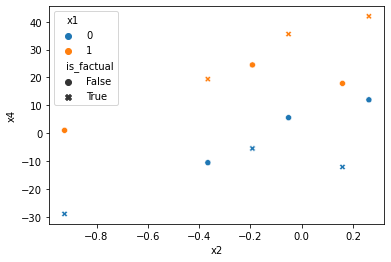

In [68]:
sns.scatterplot(data = df_all, x="x2", y="x4", hue="x1", style="is_factual")

We consider X1, X2 and X3 in the regression:

<AxesSubplot:xlabel='x2', ylabel='x3'>

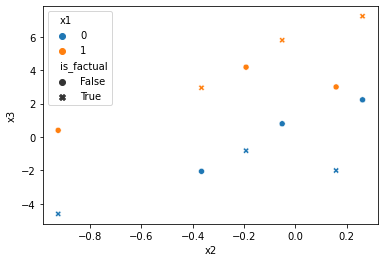

In [69]:
sns.scatterplot(data = df_all, x="x2", y="x3", hue="x1", style="is_factual")